In [6]:
from scipy.spatial import cKDTree
import numpy as np
from scipy.spatial import distance_matrix
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import pairwise_distances
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation #maybe for movies later 
from scipy.spatial import cKDTree

In [7]:
##Update with KdTree and other optimizations vectorized adjustments of clusters, The exact one to one code from MATLAB to Python resulted in very slow performance.
class dCrawler:
    def __init__(self, threshold=1.5): #just a placeholder value user need to the define at the call
        self.threshold = threshold
        self.centroids = None
        self.clusters = None

    def fit(self, points):
        self.centroids, self.clusters = self._crawler(points)
        self.centroids, self.clusters = self._adjust_clusters(points)
        self.centroids, self.clusters = self._merge_clusters(points)
        self._cleanup_clusters()
        return self

    def predict(self, points):
        if self.centroids is None or self.clusters is None:
            raise ValueError("Model not fitted yet. Call 'fit' before 'predict'.")

        kdtree = cKDTree(self.centroids)
        _, labels = kdtree.query(points)
        return labels

    def _distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _crawler(self, points):
        n = len(points)
        centroids = []
        clusters = []
        assigned = np.zeros(n, dtype=bool)

        i = 0
        while i < n:
            if not assigned[i]:
                centroid = points[i]
                cluster = [i]
                assigned[i] = True

                while True:
                    distances = np.sqrt(np.sum((points[~assigned] - centroid) ** 2, axis=1))
                    if len(distances) == 0:
                        break

                    closest_idx = np.argmin(distances)
                    closest_point = points[~assigned][closest_idx]

                    if distances[closest_idx] <= self.threshold:
                        cluster.append(np.where(~assigned)[0][closest_idx])
                        assigned[np.where(~assigned)[0][closest_idx]] = True
                        centroid = np.mean(points[cluster], axis=0)

                        distances = np.sqrt(np.sum((points[cluster] - centroid) ** 2, axis=1))
                        cluster = [c for c, d in zip(cluster, distances) if d <= self.threshold]
                        assigned[cluster] = True
                    else:
                        break

                centroids.append(centroid)
                clusters.append(cluster)

            i += 1

        return centroids, clusters

    def _adjust_clusters(self, points):
        n = len(points)
        assigned = np.zeros(n, dtype=bool)

        while True:
            kdtree = cKDTree(self.centroids)
            _, labels = kdtree.query(points)

            if np.all(assigned == labels):
                break

            assigned = labels

            for i in range(len(self.centroids)):
                cluster_points = points[labels == i]
                if len(cluster_points) > 0:
                    self.centroids[i] = np.mean(cluster_points, axis=0)

        self.clusters = [np.where(labels == i)[0] for i in range(len(self.centroids))]
        return self.centroids, self.clusters

    def _merge_clusters(self, points):
        cluster_thresh = self.threshold
        n_loop = 0

        while True:
            merged = False

            kdtree = cKDTree(self.centroids)
            distances, _ = kdtree.query(self.centroids, k=2)
            distances = distances[:, 1]

            merge_indices = np.where(distances <= cluster_thresh)[0]

            for i in merge_indices:
                j = np.argmin(np.sqrt(np.sum((self.centroids - self.centroids[i]) ** 2, axis=1)))
                if i != j:
                    self.centroids[i] = np.mean([self.centroids[i], self.centroids[j]], axis=0)
                    self.clusters[i].extend(self.clusters[j])
                    self.clusters[j] = []
                    merged = True

                    distances = np.sqrt(np.sum((points[self.clusters[i]] - self.centroids[i]) ** 2, axis=1))
                    self.clusters[i] = [c for c, d in zip(self.clusters[i], distances) if d <= self.threshold]

            if not merged:
                break

            self.centroids = [c for c, cl in zip(self.centroids, self.clusters) if len(cl) > 0]
            self.clusters = [cl for cl in self.clusters if len(cl) > 0]

            unassigned_points = np.where(np.isin(np.arange(len(points)), np.concatenate(self.clusters), invert=True))[0]

            if len(unassigned_points) > 0:
                new_centroids, new_clusters = self._crawler(points[unassigned_points])
                self.centroids.extend(new_centroids)
                self.clusters.extend(new_clusters)
                n_loop += 1

            if n_loop > 20:
                break

            cluster_thresh *= 0.95

        return self.centroids, self.clusters

    def _cleanup_clusters(self):
        cluster_ids = np.zeros(len(np.concatenate(self.clusters)), dtype=int)
        for i, cluster in enumerate(self.clusters):
            cluster_ids[cluster] = i + 1

        self.clusters = [np.where(cluster_ids == i)[0] for i in range(1, np.max(cluster_ids) + 1)]
        self.centroids = [np.mean(points[cluster], axis=0) for cluster in self.clusters]

In [10]:
# Load data from CSV
df = pd.read_csv('../DemoData/demodata.csv')
data = df.to_numpy()[:,:2]
points = data #some weird bug with the var name in the class, with fix it later
true_labels = df['Cluster'].to_numpy()

# Specify the threshold value
threshold = 1

# Create an instance of the dCrawler class
dcrawler = dCrawler(threshold=threshold)

# Fit the model
dcrawler.fit(points) #--> maybe fit_predict would be helpful here in the test?



# Predict labels for the original points
predicted_labels = dcrawler.predict(points)



print("\nNumber of Clusters:")
print(len(np.unique(predicted_labels)))


Number of Clusters:
12


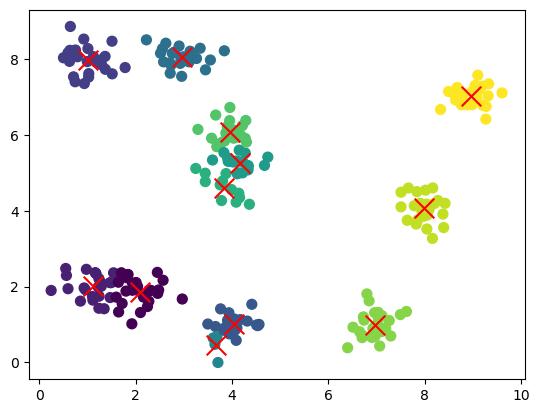

In [11]:
plt.scatter(points[:, 0], points[:, 1], c=predicted_labels, cmap='viridis', s=50)
plt.scatter(np.array(dcrawler.centroids)[:, 0], np.array(dcrawler.centroids)[:, 1], c='red', s=200, marker='x')

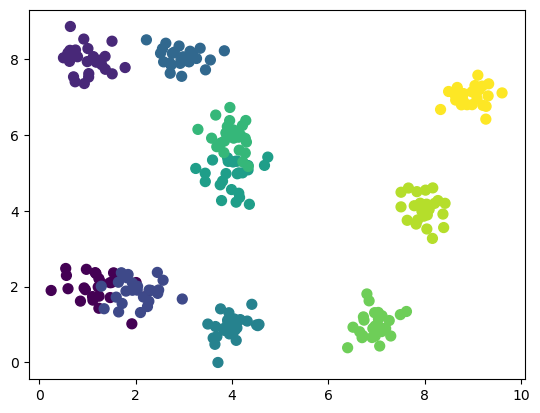

In [12]:
plt.scatter(points[:, 0], points[:, 1], c=true_labels, cmap='viridis', s=50)

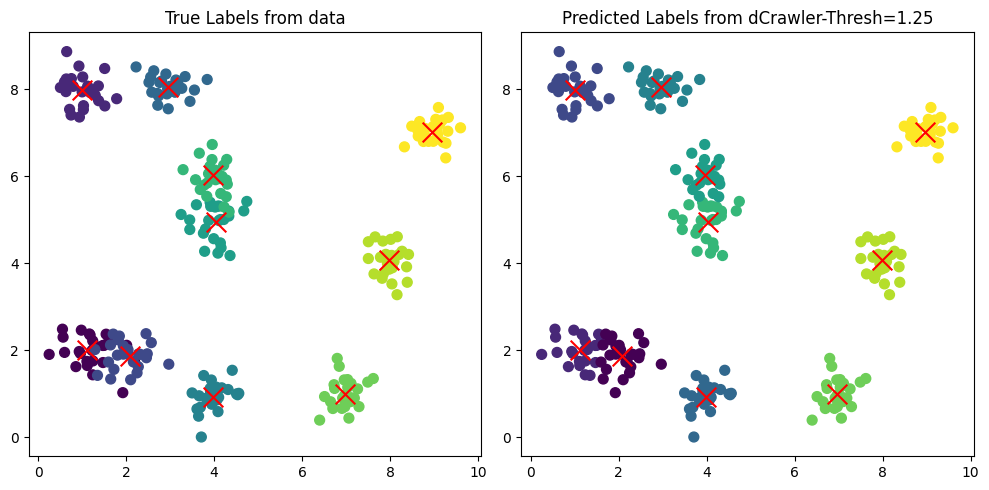

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(points[:, 0], points[:, 1], c=true_labels, cmap='viridis', s=50)
ax[1].scatter(points[:, 0], points[:, 1], c=predicted_labels, cmap='viridis', s=50)
ax[0].scatter(np.array(dcrawler.centroids)[:, 0], np.array(dcrawler.centroids)[:, 1], c='red', s=200, marker='x')
ax[1].scatter(np.array(dcrawler.centroids)[:, 0], np.array(dcrawler.centroids)[:, 1], c='red', s=200, marker='x')
ax[0].set_title('True Labels from data')
ax[1].set_title('Predicted Labels from dCrawler-Thresh=1.25')
plt.tight_layout()
plt.show();

In [7]:
th_range = [0.01, 0.1, 0.25, 0.5, 1,1.25, 1.5, 2, 5]
print(len(th_range))
print(th_range)

9
[0.01, 0.1, 0.25, 0.5, 1, 1.25, 1.5, 2, 5]


# Checking the process step by step

## Crawl

([<matplotlib.axis.YTick at 0x16f6e1550>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10')])

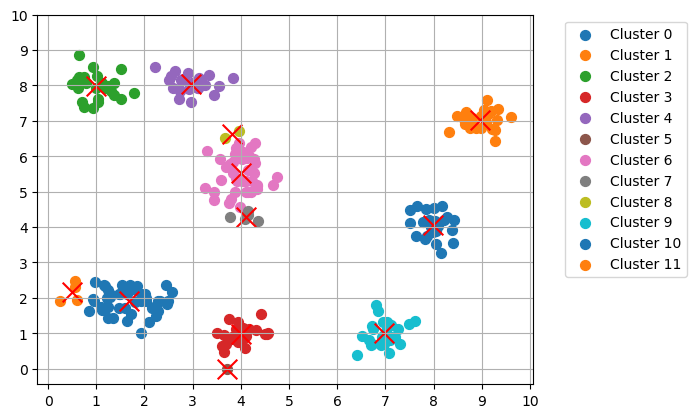

In [29]:
# Instantiate
dC = dCrawler(threshold=1.0)
# Crawl
centroids, clusters = dC._crawler(data)

#Plot after crawl
for i, centroid in enumerate(centroids):
    idx = clusters[i]
    plt.scatter(data[idx, 0], data[idx, 1], s=50, label=f"Cluster {i}")
    
    #Finally the centroid positions
    plt.scatter(centroid[0], centroid[1], c='red', s=200, marker='x')

plt.grid()
plt.legend(bbox_to_anchor=(1.05,1))
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])

Things to check here to confirm. 
* What are the distances of points in cluster 7 and 8 to those in cluster 6
* What about 3 and 5(?) those centroids look awfully close
* Do a general check to confirm that all the points are within the threshold

In [35]:
# General check to confirm all points are within the centroids allocated
for i, centroid in enumerate(centroids):
    idx = clusters[i]
    points = data[idx,:]
    distances = []
    for p in points:
        distances.append(dC._distance(p, centroid))
    max_dist = np.max(distances)
    print(f"Cluster {i} has a max distance of {max_dist}")

Cluster 0 has a max distance of 0.9222669142166213
Cluster 1 has a max distance of 0.35236727020008884
Cluster 2 has a max distance of 0.9584378114222326
Cluster 3 has a max distance of 0.7015130681335532
Cluster 4 has a max distance of 0.9012215129593557
Cluster 5 has a max distance of 0.0
Cluster 6 has a max distance of 0.9594171844774242
Cluster 7 has a max distance of 0.32330762411963754
Cluster 8 has a max distance of 0.1778883739972096
Cluster 9 has a max distance of 0.8307855025860404
Cluster 10 has a max distance of 0.8097011495226939
Cluster 11 has a max distance of 0.7238342741072424


All are good

In [37]:
#distance between 3 and 5
print(dC._distance(centroids[3],centroids[5]))

1.0104706391654419


Wow that is close but it's ok

In [41]:
# Distances of points in clusters 7 and 8, compared to cluster 6
distances_7 = []
distances_76 = []

distances_8 = []
distances_86 = []
idx_7 = clusters[7]
idx_8 = clusters[8]
points_7 = data[idx_7,:]
points_8 = data[idx_8,:]

for p in points_7:
    distances_76.append(dC._distance(p, centroids[6]))
    distances_7.append(dC._distance(p, centroids[7]))

for p in points_8:
    distances_86.append(dC._distance(p, centroids[6]))
    distances_8.append(dC._distance(p, centroids[8]))

print(distances_7)
print(distances_76)

print(distances_8)
print(distances_86)

[0.17017567538359366, 0.0748768958963711, 0.07190296247770465, 0.2839405568947006, 0.32330762411963754]
[1.065088956466084, 1.1784830979770569, 1.2942537105885907, 1.3941715891787632, 1.268174036039842]
[0.1778883739972096, 0.17788837399720925]
[1.2068608253648787, 1.0614309086210012]


Ok it all works as expected. So moving onto the adjust phase.

## Adjust phase

In [45]:
# Instantiate
dC = dCrawler(threshold=1.0)
# Crawl
dC.centroids, dC.clusters = dC._crawler(data)
dC.centroids, dC.clusters = dC._adjust_clusters(data)


([<matplotlib.axis.YTick at 0x170863ad0>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10')])

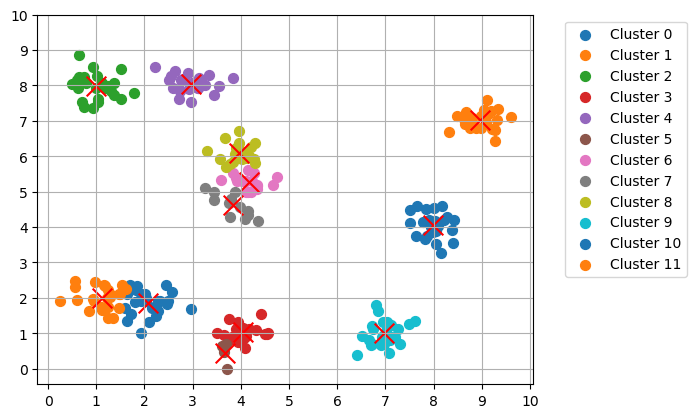

In [46]:
#Plot after crawl
for i, centroid in enumerate(dC.centroids):
    idx = dC.clusters[i]
    plt.scatter(data[idx, 0], data[idx, 1], s=50, label=f"Cluster {i}")
    
    #Finally the centroid positions
    plt.scatter(centroid[0], centroid[1], c='red', s=200, marker='x')

plt.grid()
plt.legend(bbox_to_anchor=(1.05,1))
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])

This looks reasonable, now to check the merge

## Merge Clusters
In this 3 and 5 should get merged, 6,7,8 should get merged into 2 clusters

([<matplotlib.axis.YTick at 0x1709602d0>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10')])

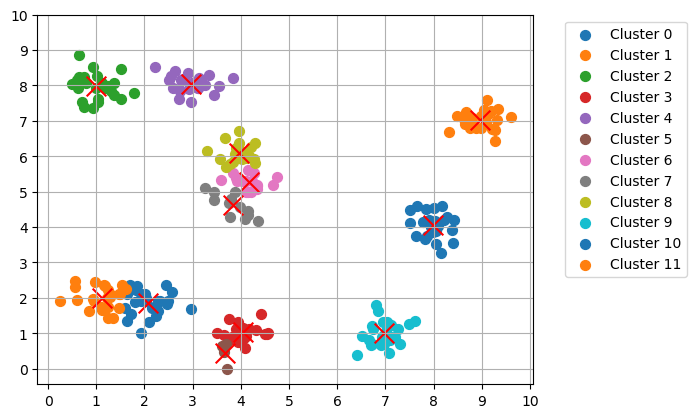

In [47]:
# Instantiate
dC = dCrawler(threshold=1.0)
# Crawl
dC.centroids, dC.clusters = dC._crawler(data)
dC.centroids, dC.clusters = dC._adjust_clusters(data)
dC.centroids, dC.clusters = dC._merge_clusters(data)

#Plot after crawl
for i, centroid in enumerate(dC.centroids):
    idx = dC.clusters[i]
    plt.scatter(data[idx, 0], data[idx, 1], s=50, label=f"Cluster {i}")
    
    #Finally the centroid positions
    plt.scatter(centroid[0], centroid[1], c='red', s=200, marker='x')

plt.grid()
plt.legend(bbox_to_anchor=(1.05,1))
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])

Ok no merging has taken place. Let's check to see what the distances are

<Axes: >

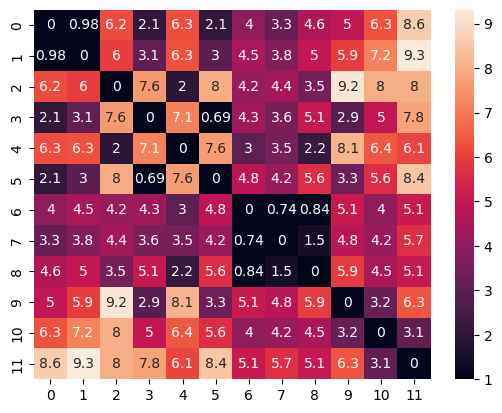

In [69]:
import seaborn as sns
Dist_mat = np.zeros([len(dC.centroids),len(dC.centroids)])
for i, c0 in enumerate(dC.centroids):
    distances = []
    for j, c1 in enumerate(dC.centroids):
        distances.append(dC._distance(c0, c1))
    Dist_mat[i,:] = distances

#fig, ax = plt.subplots()
#im = ax.imshow(Dist_mat, vmin=0, vmax=5, cmap="magma")
sns.heatmap(Dist_mat, vmin=1, annot=True)

So we have some issues here:
* Clusters 0 and 1 should be merged.
* Clusters 3 and 5 should be merged.
* Clusters 6,7,8 should be merged somehow.

Will experiment with the class to see if I can find out where the problem is in the merge.

In [103]:
##Update with KdTree and other optimizations vectorized adjustments of clusters, The exact one to one code from MATLAB to Python resulted in very slow performance.
class dCrawler_ML:
    def __init__(self, threshold=1.5): #just a placeholder value user need to the define at the call
        self.threshold = threshold
        self.centroids = None
        self.clusters = None

    def fit(self, points):
        self.centroids, self.clusters = self._crawler(points)
        self.centroids, self.clusters = self._adjust_clusters(points)
        self.centroids, self.clusters = self._merge_clusters(points)
        self._cleanup_clusters()
        return self

    def predict(self, points):
        if self.centroids is None or self.clusters is None:
            raise ValueError("Model not fitted yet. Call 'fit' before 'predict'.")

        kdtree = cKDTree(self.centroids)
        _, labels = kdtree.query(points)
        return labels

    def _distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _crawler(self, points):
        n = len(points)
        centroids = []
        clusters = []
        assigned = np.zeros(n, dtype=bool)

        i = 0
        while i < n:
            if not assigned[i]:
                centroid = points[i]
                cluster = [i]
                assigned[i] = True

                while True:
                    distances = np.sqrt(np.sum((points[~assigned] - centroid) ** 2, axis=1))
                    if len(distances) == 0:
                        break

                    closest_idx = np.argmin(distances)
                    closest_point = points[~assigned][closest_idx]

                    if distances[closest_idx] <= self.threshold:
                        cluster.append(np.where(~assigned)[0][closest_idx])
                        assigned[np.where(~assigned)[0][closest_idx]] = True
                        centroid = np.mean(points[cluster], axis=0)

                        distances = np.sqrt(np.sum((points[cluster] - centroid) ** 2, axis=1))
                        cluster = [c for c, d in zip(cluster, distances) if d <= self.threshold]
                        assigned[cluster] = True
                    else:
                        break

                centroids.append(centroid)
                clusters.append(cluster)

            i += 1

        return centroids, clusters

    def _adjust_clusters(self, points):
        n = len(points)
        assigned = np.zeros(n, dtype=bool)

        while True:
            kdtree = cKDTree(self.centroids)
            _, labels = kdtree.query(points)

            if np.all(assigned == labels):
                break

            assigned = labels

            for i in range(len(self.centroids)):
                cluster_points = points[labels == i]
                if len(cluster_points) > 0:
                    self.centroids[i] = np.mean(cluster_points, axis=0)

        self.clusters = [np.where(labels == i)[0] for i in range(len(self.centroids))]
        return self.centroids, self.clusters

    def _merge_clusters(self, points):
        cluster_thresh = self.threshold
        n_loop = 0

        while True:
            merged = False
            kdtree = cKDTree(self.centroids)
            distances, _ = kdtree.query(self.centroids, k=2)
            distances = distances[:, 1]

            merge_indices = np.where(distances <= cluster_thresh)[0]
            #Removed list - this needs to be added to account for the fact that if the cluster has already been merged then we skip it
            removed_list = []
            for i in merge_indices:
                #j = np.argmin(np.sqrt(np.sum((self.centroids - self.centroids[i]) ** 2, axis=1))) --> Here's the problem this should find the second one instead, because the minimum will be itself
                ds = np.sqrt(np.sum((self.centroids - self.centroids[i]) ** 2, axis=1)) # Get all the distances
                ds[i] = cluster_thresh #change it to the cluster thresh
                j = np.argmin(ds) #so now j should be different to i unless it is above the cluster_threshold

                if i != j:
                    if i not in removed_list:
                        self.centroids[i] = np.mean([self.centroids[i], self.centroids[j]], axis=0) #
                        #self.clusters[i].extend(self.clusters[j]) --> you can't extend a numpy array will concatenate instead
                        self.clusters[i] = np.concatenate((self.clusters[i], self.clusters[j]))
                        self.clusters[j] = []
                        merged = True
                        distances = np.sqrt(np.sum((points[self.clusters[i]] - self.centroids[i]) ** 2, axis=1))
                        self.clusters[i] = [c for c, d in zip(self.clusters[i], distances) if d <= self.threshold]
                        removed_list.append(j) #add j to the exclude list
            if not merged:
                break

            self.centroids = [c for c, cl in zip(self.centroids, self.clusters) if len(cl) > 0]
            self.clusters = [cl for cl in self.clusters if len(cl) > 0]

            unassigned_points = np.where(np.isin(np.arange(len(points)), np.concatenate(self.clusters), invert=True))[0]

            if len(unassigned_points) > 0:
                new_centroids, new_clusters = self._crawler(points[unassigned_points])
                self.centroids.extend(new_centroids)
                self.clusters.extend(new_clusters)
                n_loop += 1
            
            #Add in the adjust step
            self.centroids, self.clusters = self._adjust_clusters(points)
            
            if n_loop > 20:
                break

            cluster_thresh *= 0.95

        return self.centroids, self.clusters

    def _cleanup_clusters(self):
        cluster_ids = np.zeros(len(np.concatenate(self.clusters)), dtype=int)
        for i, cluster in enumerate(self.clusters):
            cluster_ids[cluster] = i + 1

        self.clusters = [np.where(cluster_ids == i)[0] for i in range(1, np.max(cluster_ids) + 1)]
        self.centroids = [np.mean(points[cluster], axis=0) for cluster in self.clusters]

In [104]:
# Instantiate
dC_ML = dCrawler_ML(threshold=1.0)
# Crawl
dC_ML.centroids, dC_ML.clusters = dC_ML._crawler(data)
dC_ML.centroids, dC_ML.clusters = dC_ML._adjust_clusters(data)
dC_ML.centroids, dC_ML.clusters = dC_ML._merge_clusters(data)

([<matplotlib.axis.YTick at 0x1740042d0>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10')])

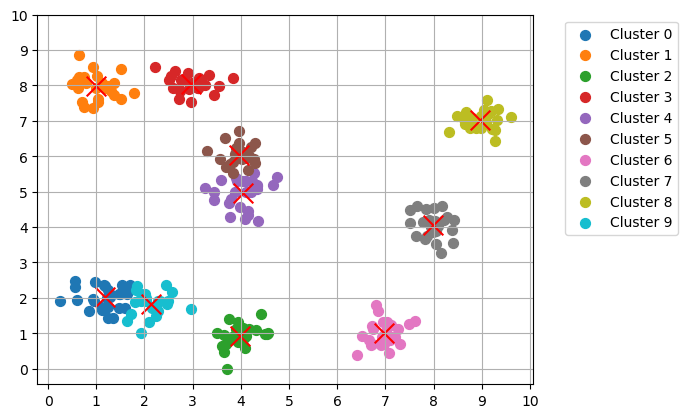

In [105]:
#Plot after crawl
for i, centroid in enumerate(dC_ML.centroids):
    idx = dC_ML.clusters[i]
    plt.scatter(data[idx, 0], data[idx, 1], s=50, label=f"Cluster {i}")
    
    #Finally the centroid positions
    plt.scatter(centroid[0], centroid[1], c='red', s=200, marker='x')

plt.grid()
plt.legend(bbox_to_anchor=(1.05,1))
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])

# Do a range of classes

In [106]:
cls = []
cents = []
th_range = [0.1, 0.25, 0.3, 0.5, 0.75, 1, 2, 5, 10]
for th in th_range:
    print(f'Threshold:{th}')
    dcrawler = dCrawler_ML(threshold=th)
    dcrawler.fit(data)
    predicted_labels = dcrawler.predict(data)
    cls.append(predicted_labels)
    cents.append(dcrawler.centroids)

Threshold:0.1
Threshold:0.25
Threshold:0.3
Threshold:0.5


IndexError: arrays used as indices must be of integer (or boolean) type

IndexError: list index out of range

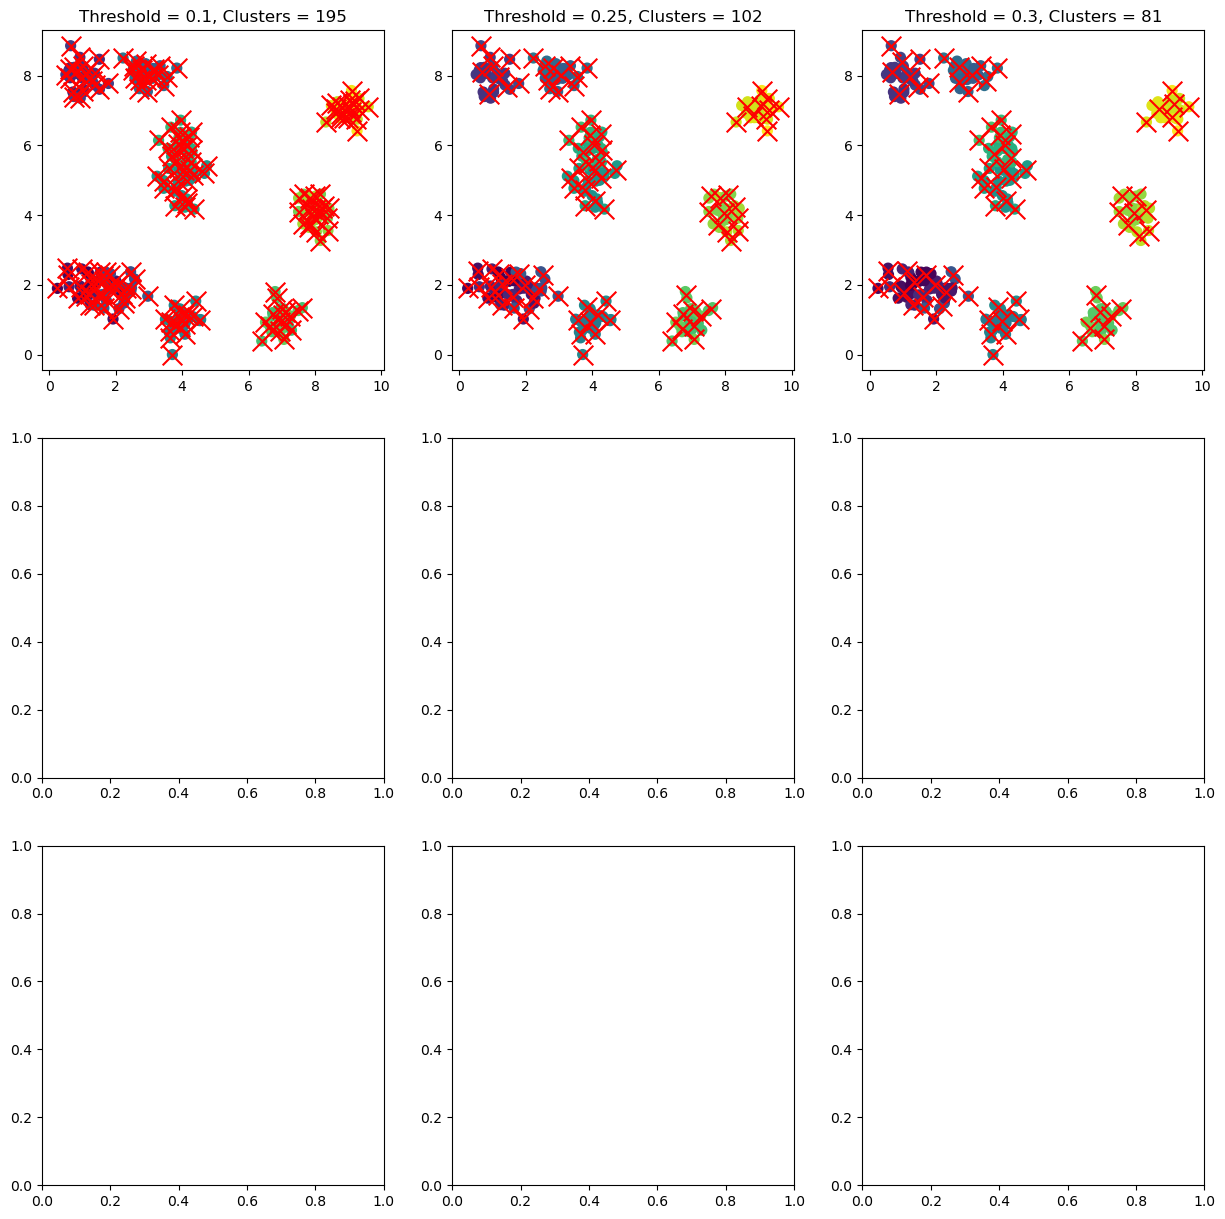

In [101]:
# Plotting the clusters for different threshold values
points = data
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        ax[i, j].scatter(points[:, 0], points[:, 1], c=cls[i*3+j], cmap='viridis', s=50)
        ax[i, j].scatter(np.array(cents[i*3+j])[:, 0], np.array(cents[i*3+j])[:, 1], c='red', s=200, marker='x')
        ax[i, j].set_title(f'Threshold = {th_range[i*3+j]}, Clusters = {len(np.unique(cls[i*3+j]))}')
plt.tight_layout()
plt.show();

In [ ]:
gene_exp = pd.read_csv('Breast_GSE45827.csv')
gene_exp.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [ ]:
X = gene_exp.iloc[:, 2:].values  # Exclude the 'samples' and 'type' columns

In [ ]:
threshold = 1.25 # Adjust the threshold value based on your data and desired clustering granularity
clust_gen = dCrawler(threshold=threshold)

In [ ]:
X.shape

(151, 54675)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [ ]:
cls_gen = clust_gen.fit(X_reduced)
labels = clust_gen.predict(X_reduced)

In [ ]:
pca_data = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])
pca_data['Cluster'] = labels

In [ ]:
pca_data.head()

,PC1,PC2,Cluster
0,83.321029,-49.633867,108
1,65.058272,-55.857032,109
2,108.653751,-15.956774,108
3,55.402867,-65.215959,109
4,57.063095,-61.080824,109


In [ ]:
len(np.unique(labels))

8

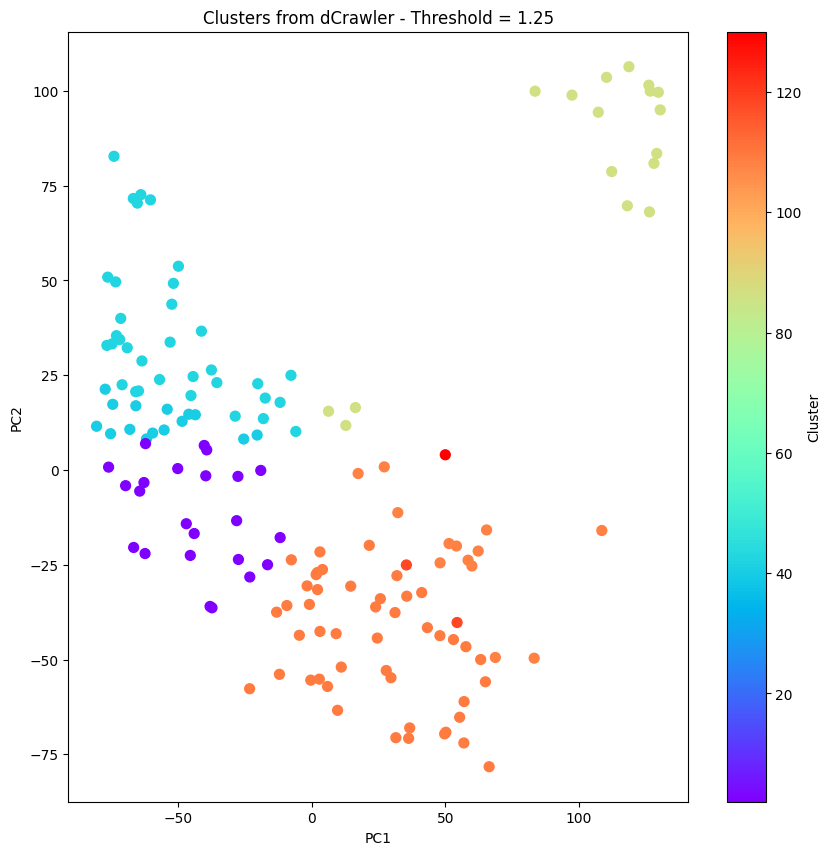

In [19]:
# Plotting the clusters
plt.figure(figsize=(10, 10))
plt.scatter(pca_data['PC1'], pca_data['PC2'], c=pca_data['Cluster'], cmap='rainbow', s=50)
plt.title(f'Clusters from dCrawler - Threshold = {threshold}')
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show();